# Features for Microglia in P6 mouse Cortex

In [1]:
!pip install scProject -U
import random
random.seed(a=613)
import numpy as np
import scProject
import scanpy as sc
patterns = sc.read_h5ad('patterns_anndata.h5ad')
dataset = sc.read_h5ad('/Users/asherbaraban/PycharmProjects/scProject/scProject/test/targetALS_elim_annotated_20200510/p6counts.h5ad')
dataset_filtered, patterns_filtered = scProject.matcher.filterAnnDatas(dataset, patterns, 'id')
print(dataset.shape)


/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(50127, 2996) dataset filter shape
(80, 2996) patterns filter shape


Trying to set attribute `.X` of view, copying.
Trying to set attribute `.X` of view, copying.


(50127, 18019)


Low regularization low 1% lasso

In [2]:
import matplotlib.pyplot as plt
from sklearn import linear_model
plt.rcParams['figure.figsize']= [10, 12]
dataset_filtered = scProject.matcher.logTransform(dataset_filtered)
# used to be .0001
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'MG01', .0001, .01, layer='log', iterations=100000)
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'assigned_cell_type', 11, 'MG01', 'MG01Pears', True, display=False, path='PearsonMicrgliaLowReg.pdf')



A layer named 'log' has been added to your filtered dataset
Regressing on loglayer of dataset_filtered
(50127, 80)
['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', 'Vascular Endothelium', ..., 'Cycling Neural Progenitor', 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']
Length: 11
Categories (11, object): ['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', ..., 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']


In [3]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'assigned_cell_type', 'MG01', 'UMAPMG01', 20, display=False, path='UMAPlowReg.pdf')

['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', 'Vascular Endothelium', ..., 'Cycling Neural Progenitor', 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']
Length: 11
Categories (11, object): ['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', ..., 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']


In [4]:

scProject.viz.featurePlots(dataset_filtered, [24,5,6,25,57,58] , 'MG01', 'UMAPMG01', display=False, path='MGLowReg')

Number of nonzero cells 19580
Number of nonzero cells 32546
Number of nonzero cells 39184
Number of nonzero cells 47086
Number of nonzero cells 13231
Number of nonzero cells 32650


As expected from the Pearson plot, features 5 and 24 are the stronger markers of microglia in the P6 mouse cortex. Lets up the lasso to encourage sparsity and strengthen the features that are the real drivers.

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [10, 12]
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'MG99', .0005, .99, layer='log')
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'assigned_cell_type', 11, 'MG99', 'MG99Pears', True,display=False,row_cluster=False, col_cluster=False,path='MicrogliaPearsonHighReg.pdf')






Regressing on loglayer of dataset_filtered
(50127, 80)
['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', 'Vascular Endothelium', ..., 'Cycling Neural Progenitor', 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']
Length: 11
Categories (11, object): ['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', ..., 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']


/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [6]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'assigned_cell_type', 'MG99', 'UMAPMG99', 20,display=False, path='UMAPMGHighReg.pdf')

['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', 'Vascular Endothelium', ..., 'Cycling Neural Progenitor', 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']
Length: 11
Categories (11, object): ['Darpp-32 Interneurons', 'Excitatory Neurons', 'Astrocytes/Radial Glia', 'Oligodendrocytes', ..., 'Brain Fibroblasts', 'Microglia', 'Cajal-Retzius Cells', 'Vascular Smooth Muscle']


One nice feature of scProject is that you can use the UMAP coordinates generated from a previous regression. This can be useful when you increase the regularization and the UMAPs become harder to decipher. These are the feature plots, but on the original UMAP coordinates.

In [7]:
scProject.viz.featurePlots(dataset_filtered, [24,5,6,25,57,58], 'MG99', 'UMAPMG01',display=False, path='MGHighReg')

Number of nonzero cells 1818
Number of nonzero cells 38
Number of nonzero cells 44
Number of nonzero cells 75
Number of nonzero cells 706
Number of nonzero cells 240


This is the typical feature weights on a newly generated UMAP coordinate system.

In [8]:
scProject.viz.featurePlots(dataset_filtered, [24,5,6,25,57,58], 'MG99', 'UMAPMG99', obsColumn='assigned_cell_type',display=False,path='f5Micro')


Number of nonzero cells 1818
Number of nonzero cells 38
Number of nonzero cells 44
Number of nonzero cells 75
Number of nonzero cells 706
Number of nonzero cells 240


While this is clearly over regularized some features 5, 6 and 75(because of how many nonzero cells) persist. Lets print out the highest expressed genes from the features of interest and see what's inside.

In [9]:
print(scProject.stats.importantGenes(patterns_filtered, 5, .05), "Feature 5 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 6, .05), "Feature 6 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 24, .1), "Feature 24 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 57, .01), "Feature 57 Genes")

[Index(['ENSMUSG00000049775'], dtype='object', name='index')] Feature 5 Genes
[Index(['ENSMUSG00000049775', 'ENSMUSG00000030220', 'ENSMUSG00000030560',
       'ENSMUSG00000068220'],
      dtype='object', name='index')] Feature 6 Genes
[Index(['ENSMUSG00000060802', 'ENSMUSG00000027447', 'ENSMUSG00000049775',
       'ENSMUSG00000036905', 'ENSMUSG00000036896', 'ENSMUSG00000036887',
       'ENSMUSG00000029580', 'ENSMUSG00000002985', 'ENSMUSG00000030579',
       'ENSMUSG00000021939', 'ENSMUSG00000022108', 'ENSMUSG00000021190'],
      dtype='object', name='index')] Feature 24 Genes
[Index(['ENSMUSG00000025939', 'ENSMUSG00000026154', 'ENSMUSG00000026126',
       'ENSMUSG00000026223', 'ENSMUSG00000026385', 'ENSMUSG00000026457',
       'ENSMUSG00000026473', 'ENSMUSG00000051319', 'ENSMUSG00000017707',
       'ENSMUSG00000045503', 'ENSMUSG00000000826', 'ENSMUSG00000040229',
       'ENSMUSG00000025630', 'ENSMUSG00000025283', 'ENSMUSG00000027706',
       'ENSMUSG00000036353', 'ENSMUSG00000027763', 

In short, Feature 24 which is expressed in a fraction of microglia has high expression of C1qa, C1qb, C1qc genes. Feature 24 is not included in all of the microglia suggesting that there exists a subtype of microglia in the P6 mouse cortex that expresses C1qa through c in much higher amounts. Features 5, 6, and 75 do not have the C1qs expressed in their most important genes. This shows a subtyping of microglia in terms of expression of C1q expression.

To better understand the expression of C1q a-c, lets use gene selectivity to understand what the model is doing.

Feature 5 expresses 8.806652575731277% of gene ENSMUSG00000036887
Feature 6 expresses 5.772949382662773% of gene ENSMUSG00000036887
Feature 24 expresses 56.590402126312256% of gene ENSMUSG00000036887


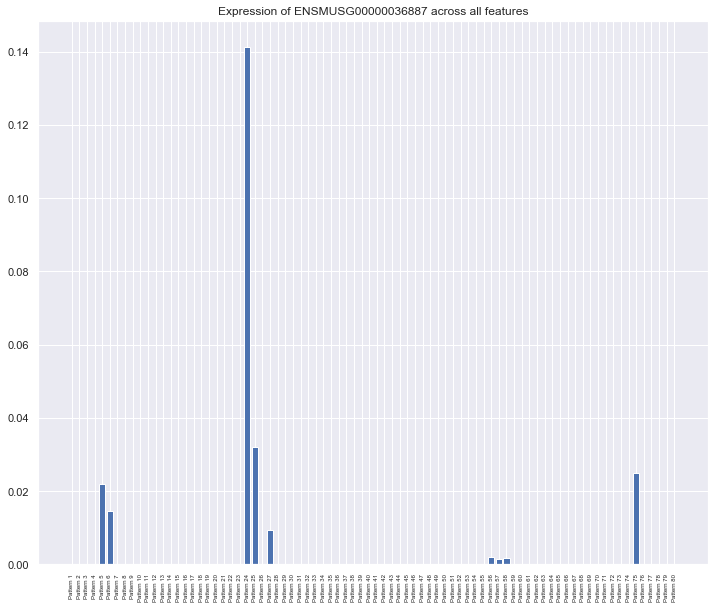

Feature 5 expresses 9.958536177873611% of gene ENSMUSG00000036905
Feature 6 expresses 8.675467222929% of gene ENSMUSG00000036905
Feature 24 expresses 46.156883239746094% of gene ENSMUSG00000036905


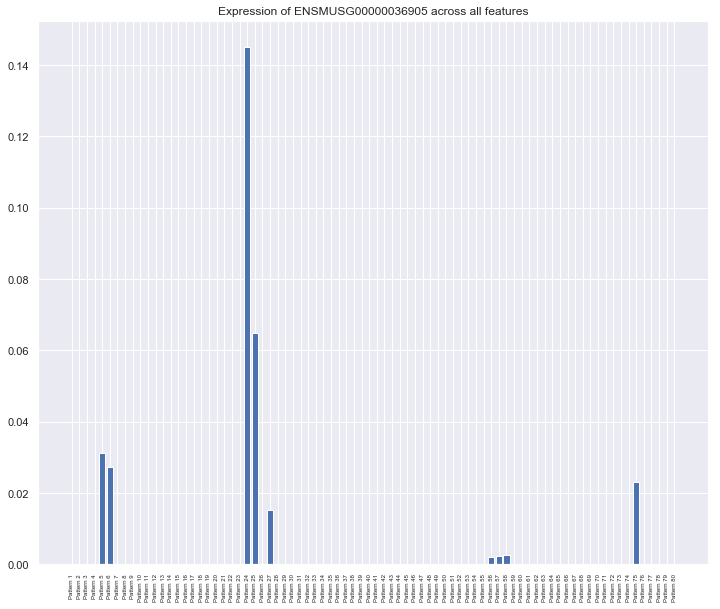

Feature 5 expresses 10.352037101984024% of gene ENSMUSG00000036896
Feature 6 expresses 6.393595039844513% of gene ENSMUSG00000036896
Feature 24 expresses 49.75306689739227% of gene ENSMUSG00000036896


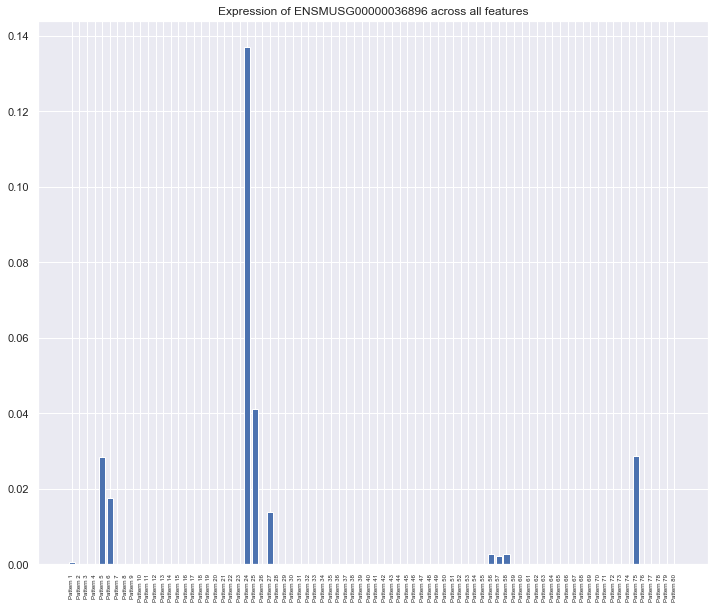

(415, 80)


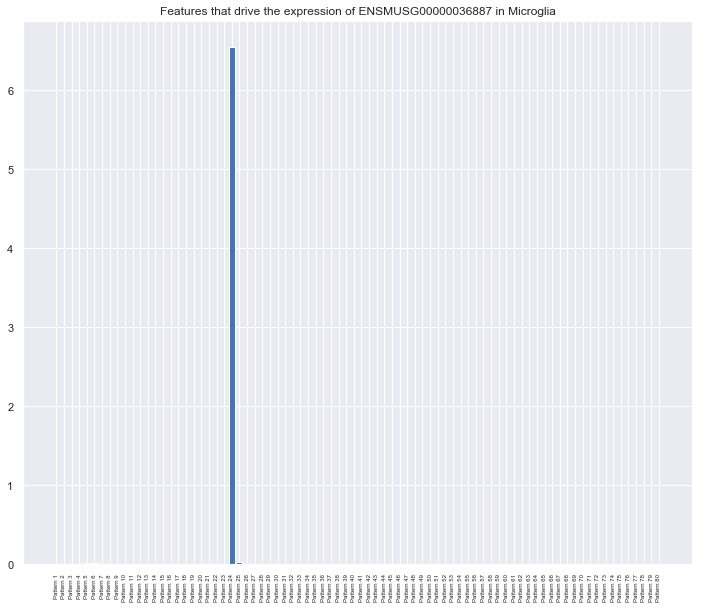

(415, 80)


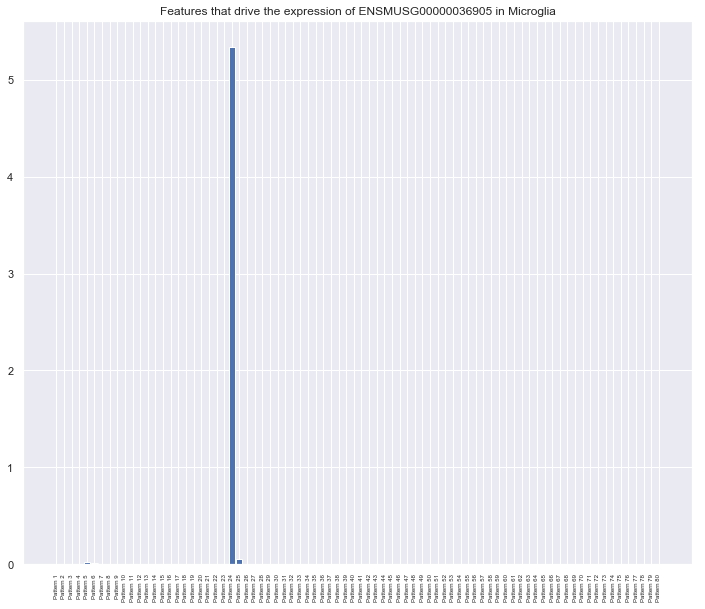

(415, 80)


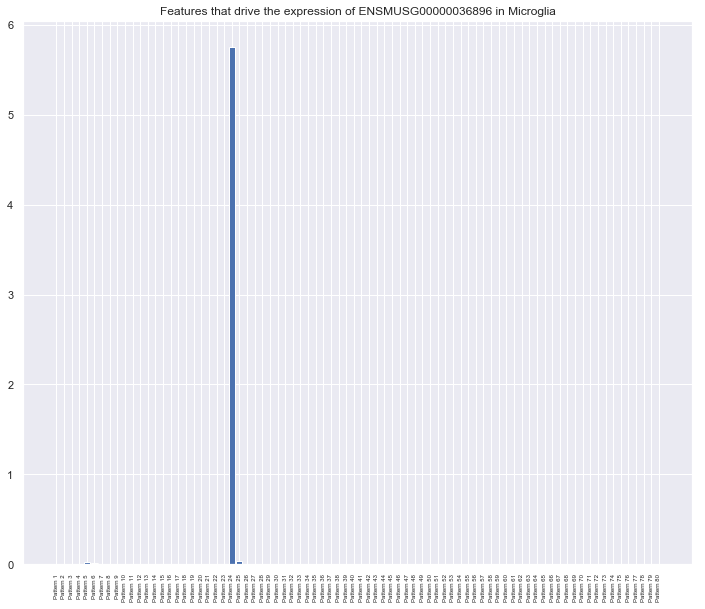

In [10]:
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 5, False) #C1qa
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 6, False) #C1qa
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 24, True) #C1qa

scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 5, False) #C1qb
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 6, False) #C1qb
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 24, True) #C1qb

scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 5, False) #C1qc
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 6, False) #C1qc
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 24, True) #C1qc

scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036887', 'assigned_cell_type',
                                       "Microglia", "MG99")
scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036905', 'assigned_cell_type',
                                       "Microglia", "MG99")
scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036896', 'assigned_cell_type',
                                       "Microglia", "MG99")

Feature 24 expresses 18.94414722919464% of gene ENSMUSG00000059498


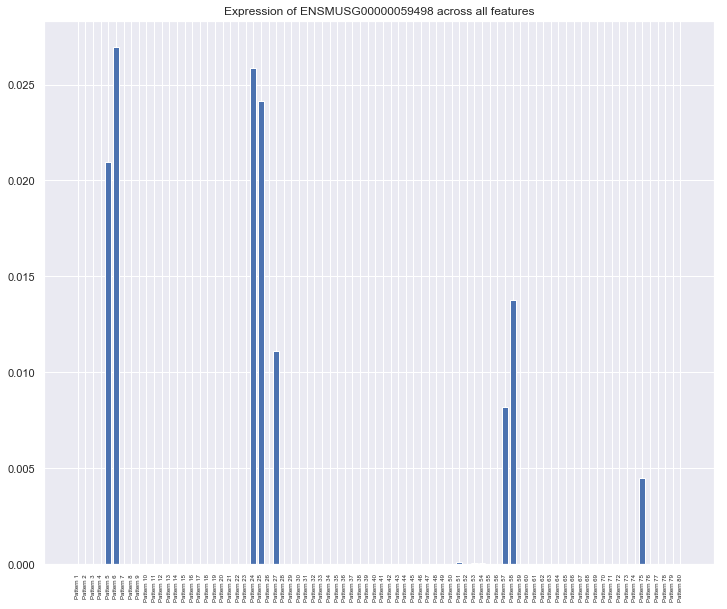

In [11]:
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000059498', 24, True)

The model chose the best features to use in the samples. As we saw in the previous plots, feature 5 is the largest driver of microglia. It is important to note that these plots take the average of all of the cells annotated as microglia, but from the feature plots we know that some microglia express more of feature 6 and others more feature 24. The first plots clearly show that feature 24 expresses much more of all three genes. Next, we show the utility of the stats in scProject to see which genes are driving the difference between subtypes. Below, I split the microglia into two groups based on their expression of feature 6.

/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


This subset has shape: (415, 2996)


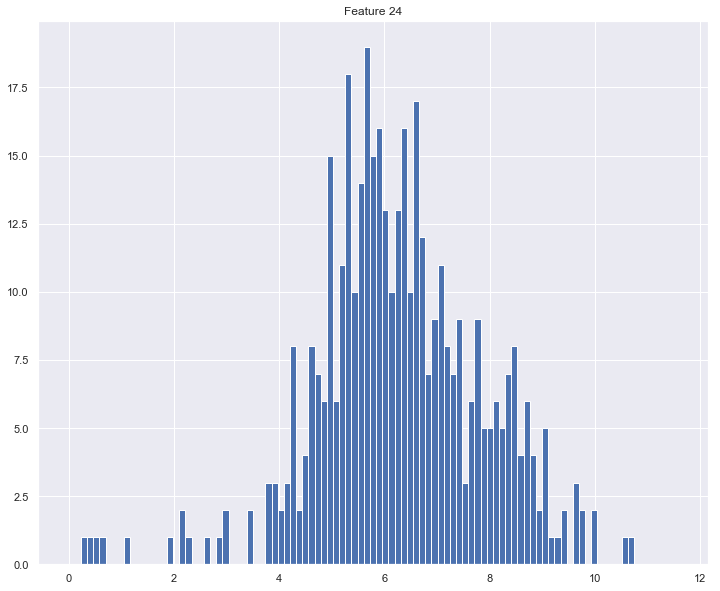

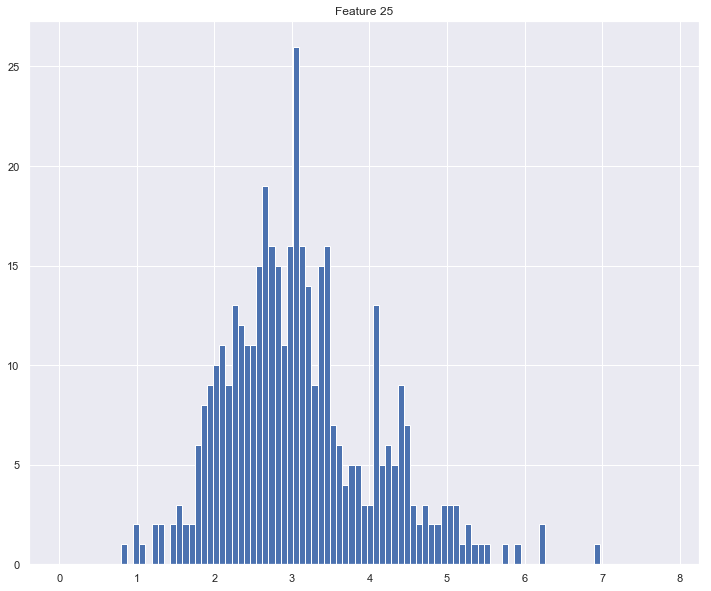

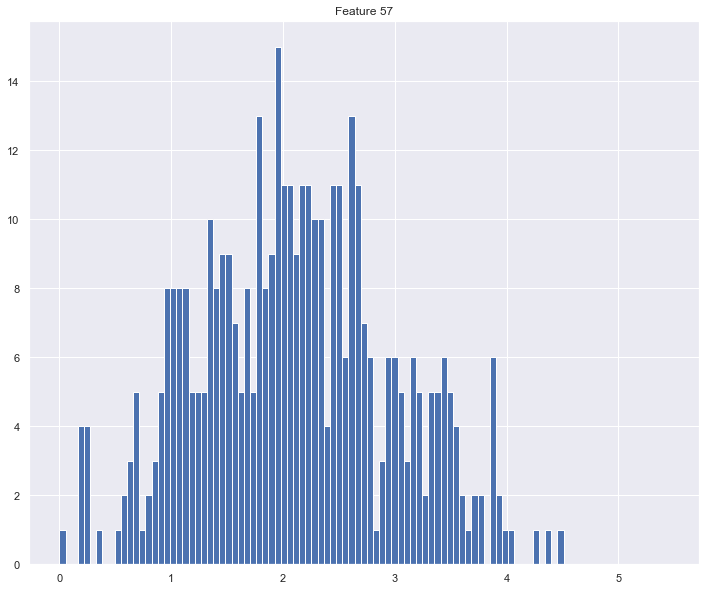

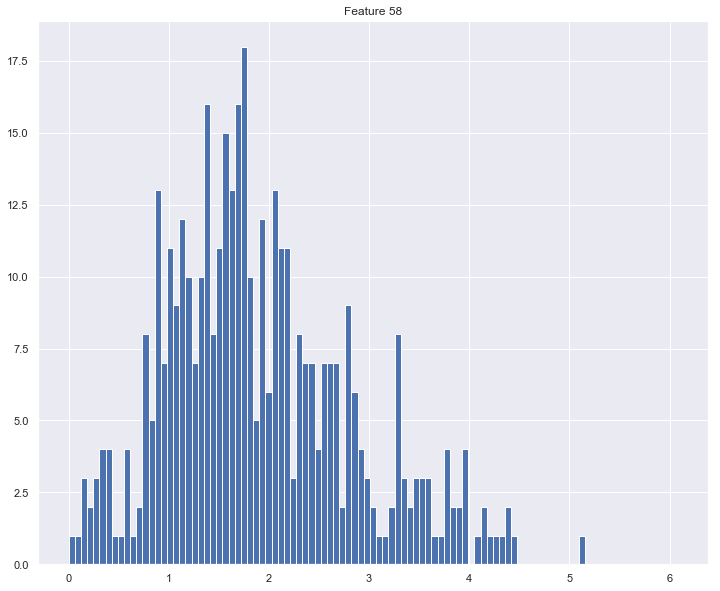

In [12]:
# histograms to see expression of feature 24 and 57 in microglia
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.patternWeightDistribution(dataset_filtered, 'MG01', [24,25, 57,58], obsColumn='assigned_cell_type', subset=['Microglia'], numBins=100)


(415, 2996) (49712, 2996) (50127, 2996)
C1 is dense
C2 is dense


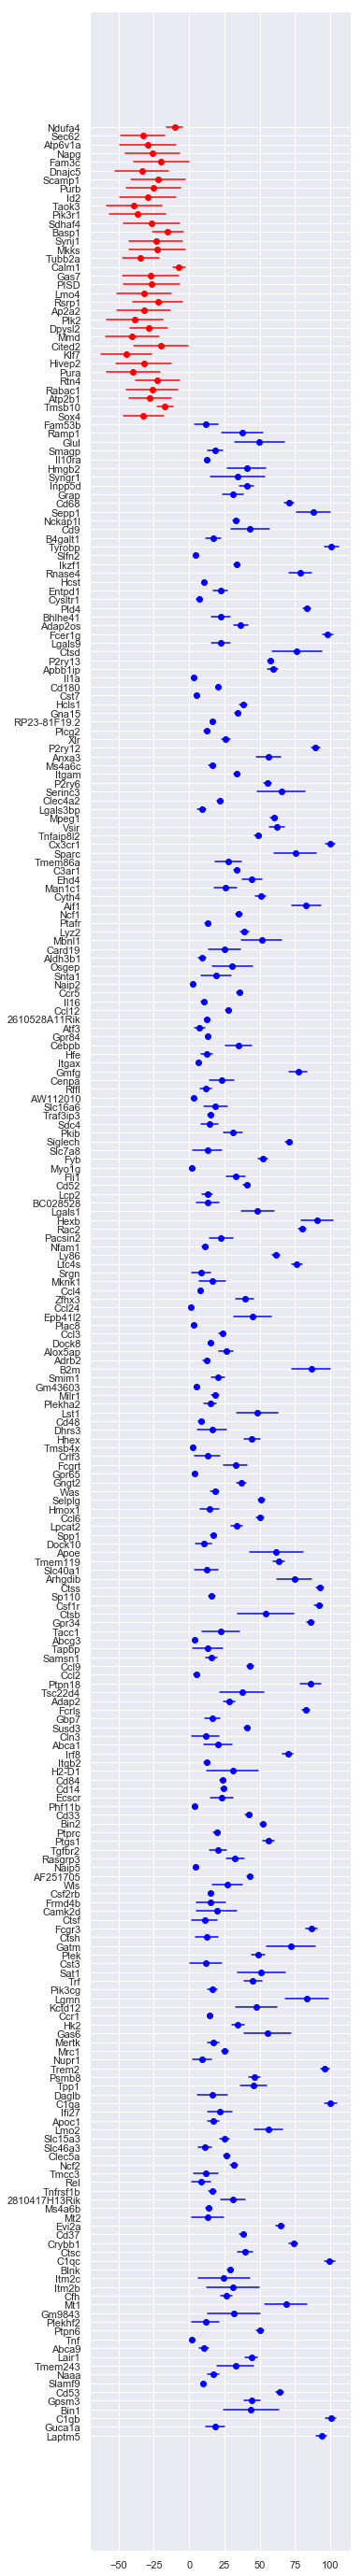

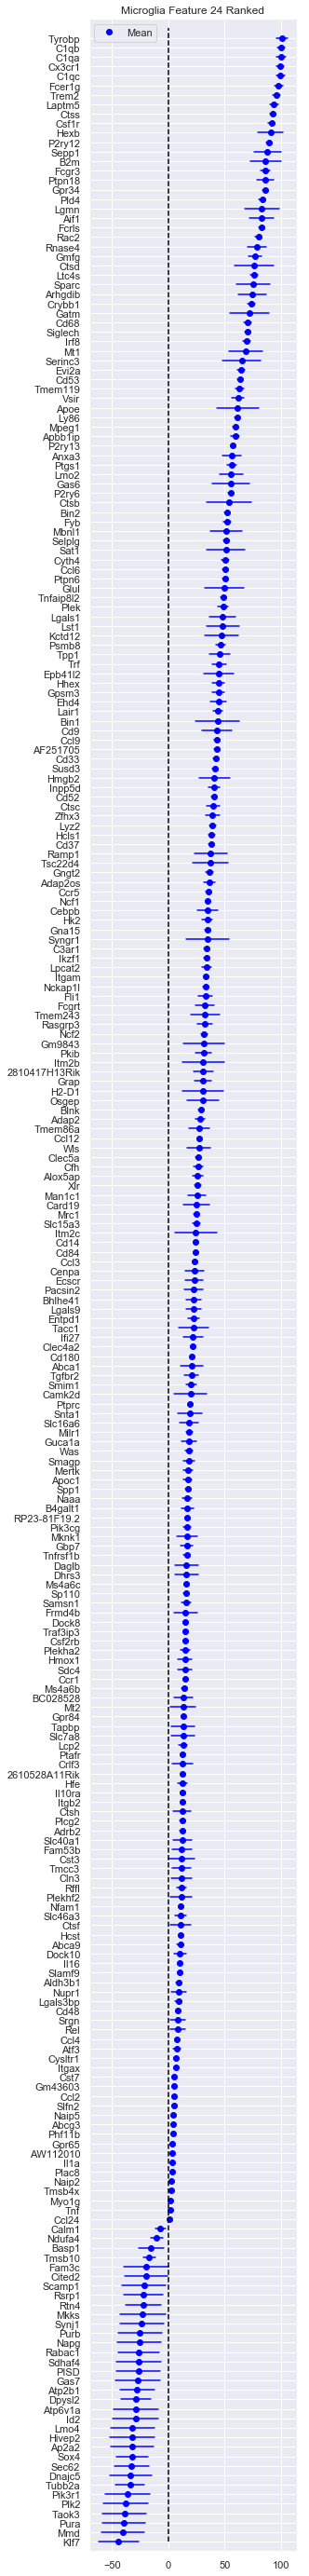

In [13]:
import numpy as np
microglia= dataset_filtered[dataset_filtered.obs['assigned_cell_type'].isin(['Microglia'])].copy()
others= dataset_filtered.obs['assigned_cell_type'].unique().remove_categories('Microglia')
rest = dataset_filtered[dataset_filtered.obs['assigned_cell_type'].isin(list(others))].copy()
print(microglia.shape, rest.shape, dataset_filtered.shape)

microglia.X = np.log2(microglia.X + 1e-30) #log transform for statistical tests
rest.X = np.log2(rest.X + 1e-30) #log transform for statistcal tests

plt.rcParams['figure.figsize']= [5,50]
df24 = scProject.stats.projectionDriver(patterns_filtered, microglia, rest,.999999999999,'gene_short_name', 24)

f24CIs = df24[0]

f24CIs['rank'] = (f24CIs['High']+f24CIs['Low'])/2.0
f24CIsRank = f24CIs.sort_values(by='rank', ascending=True)
counter = 0
yAxis = []
plt.rcParams['figure.figsize']= [4, 50]
for idx,low, high,y in zip(list(f24CIsRank.index) ,f24CIsRank['Low'], f24CIsRank['High'], range(len(f24CIsRank))):
    plt.plot((low, high), (counter, counter), '-', color='blue')
    if counter is 0:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue', label='Mean')
    else:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue')
    yAxis.append(idx)
    counter+=1

plt.yticks(range(len(yAxis)), yAxis)
plt.title("Microglia Feature 24 Ranked")
plt.plot((0,0), (0,len(yAxis)), '--', color='black')
plt.ylim(top= len(yAxis)+1)
plt.ylim(bottom=-1)
plt.legend()
plt.savefig("Microglia24Ranked.pdf", bbox_inches='tight')
plt.show()

C1 is dense
C2 is dense


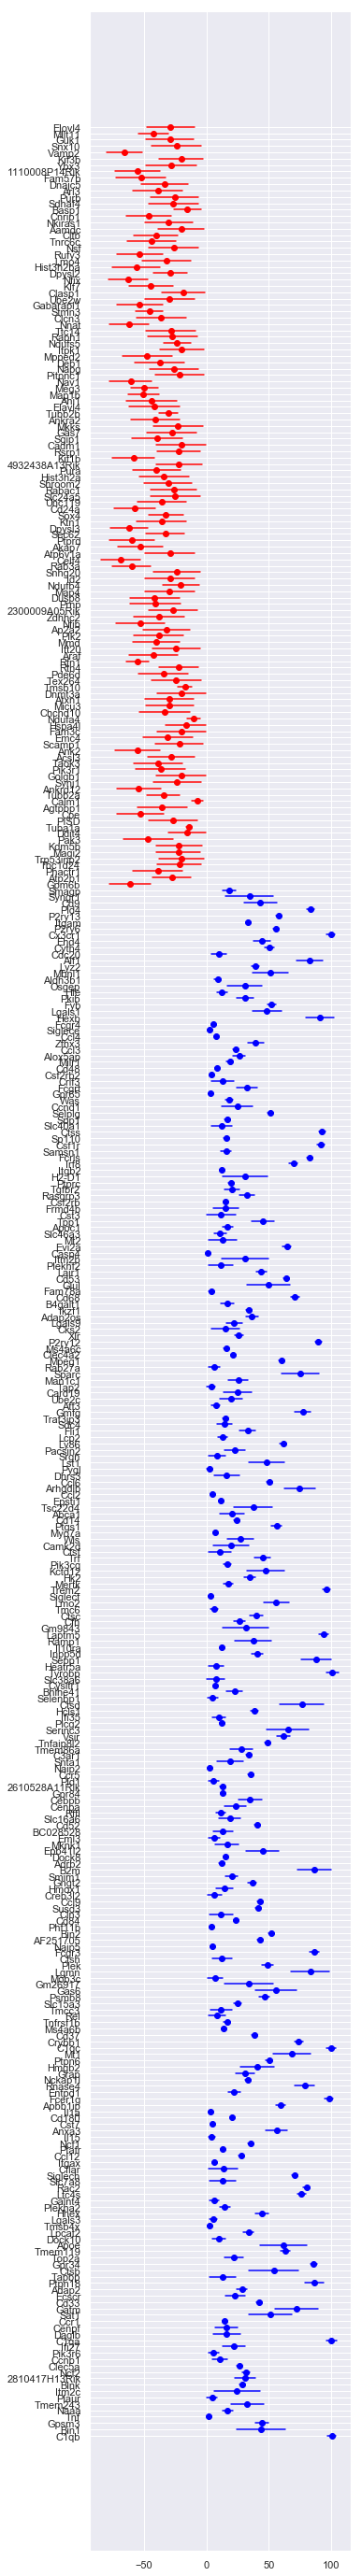

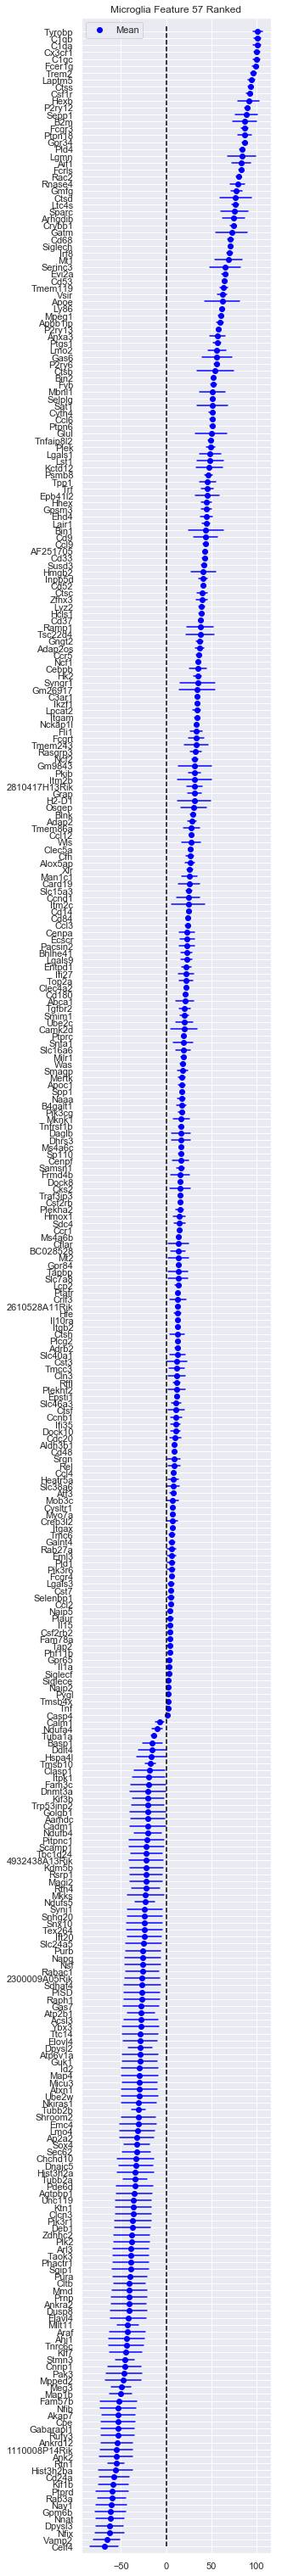

In [14]:
plt.rcParams['figure.figsize']= [5,50]
df57 = scProject.stats.projectionDriver(patterns_filtered, microglia, rest,.999999999999,'gene_short_name', 57)

f57CIs = df57[0]

f57CIs['rank'] = (f57CIs['High']+f57CIs['Low'])/2.0
f57CIsRank = f57CIs.sort_values(by='rank', ascending=True)
counter = 0
yAxis = []
plt.rcParams['figure.figsize']= [4, 55]
for idx,low, high,y in zip(list(f57CIsRank.index) ,f57CIsRank['Low'], f57CIsRank['High'], range(len(f57CIsRank))):
    plt.plot((low, high), (counter, counter), '-', color='blue')
    if counter is 0:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue', label='Mean')
    else:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue')
    yAxis.append(idx)
    counter+=1

plt.yticks(range(len(yAxis)), yAxis)
plt.title("Microglia Feature 57 Ranked")
plt.plot((0,0), (0,len(yAxis)), '--', color='black')
plt.ylim(top= len(yAxis)+1)
plt.ylim(bottom=-1)
plt.legend()
plt.savefig("Microglia57Ranked.pdf", bbox_inches='tight')
plt.show()

In [15]:
genes24 = set(df24[0].index)
genes57 = set(df57[0].index)

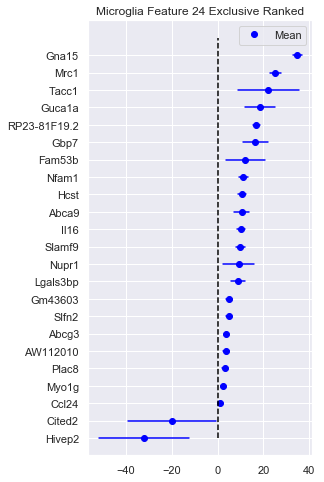

In [16]:
in24 = genes24.difference(genes57)
just24CIs = df24[0].loc[in24]

just24CIs['rank'] = (just24CIs['High']+just24CIs['Low'])/2.0
just24CIsRank = just24CIs.sort_values(by='rank', ascending=True)
counter = 0
yAxis = []
plt.rcParams['figure.figsize']= [4, 8]
for idx,low, high,y in zip(list(just24CIsRank.index) ,just24CIsRank['Low'], just24CIsRank['High'], range(len(just24CIsRank))):
    plt.plot((low, high), (counter, counter), '-', color='blue')
    if counter is 0:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue', label='Mean')
    else:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue')
    yAxis.append(idx)
    counter+=1

plt.yticks(range(len(yAxis)), yAxis)
plt.title("Microglia Feature 24 Exclusive Ranked")
plt.plot((0,0), (0,len(yAxis)), '--', color='black')
plt.ylim(top= len(yAxis)+1)
plt.ylim(bottom=-1)
plt.legend()
plt.savefig("JustMicroglia24.pdf", bbox_inches='tight')
plt.show()

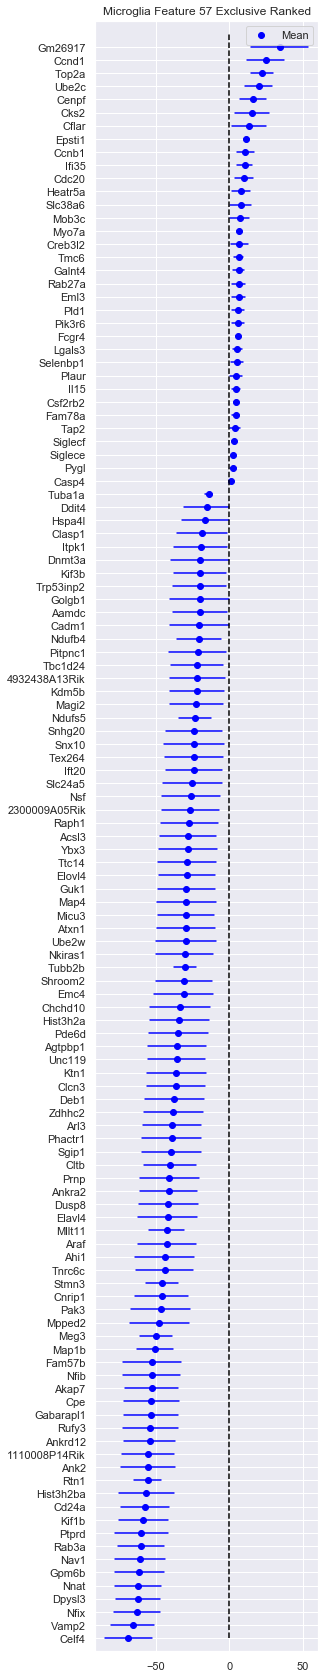

In [17]:
in57 = genes57.difference(genes24)
just57CIs = df57[0].loc[in57]

just57CIs['rank'] = (just57CIs['High']+just57CIs['Low'])/2.0
just57CIsRank = just57CIs.sort_values(by='rank', ascending=True)
counter = 0
yAxis = []
plt.rcParams['figure.figsize']= [4, 30]
for idx,low, high,y in zip(list(just57CIsRank.index) ,just57CIsRank['Low'], just57CIsRank['High'], range(len(just57CIsRank))):
    plt.plot((low, high), (counter, counter), '-', color='blue')
    if counter is 0:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue', label='Mean')
    else:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue')
    yAxis.append(idx)
    counter+=1

plt.yticks(range(len(yAxis)), yAxis)
plt.title("Microglia Feature 57 Exclusive Ranked")
plt.plot((0,0), (0,len(yAxis)), '--', color='black')
plt.ylim(top= len(yAxis)+1)
plt.ylim(bottom=-1)
plt.legend()
plt.savefig("JustMicroglia57.pdf", bbox_inches='tight')
plt.show()

/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(415, 2996) (49712, 2996) (50127, 2996)
C1 is dense
C2 is dense


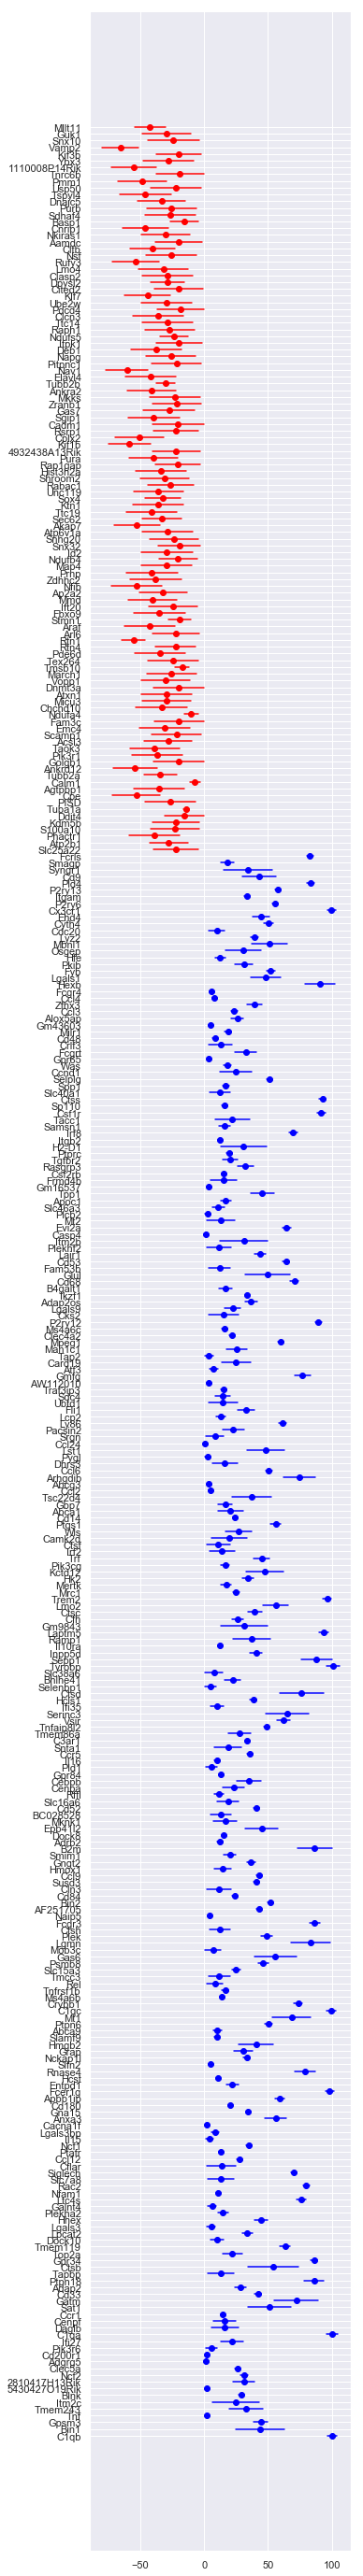

C1 is dense
C2 is dense


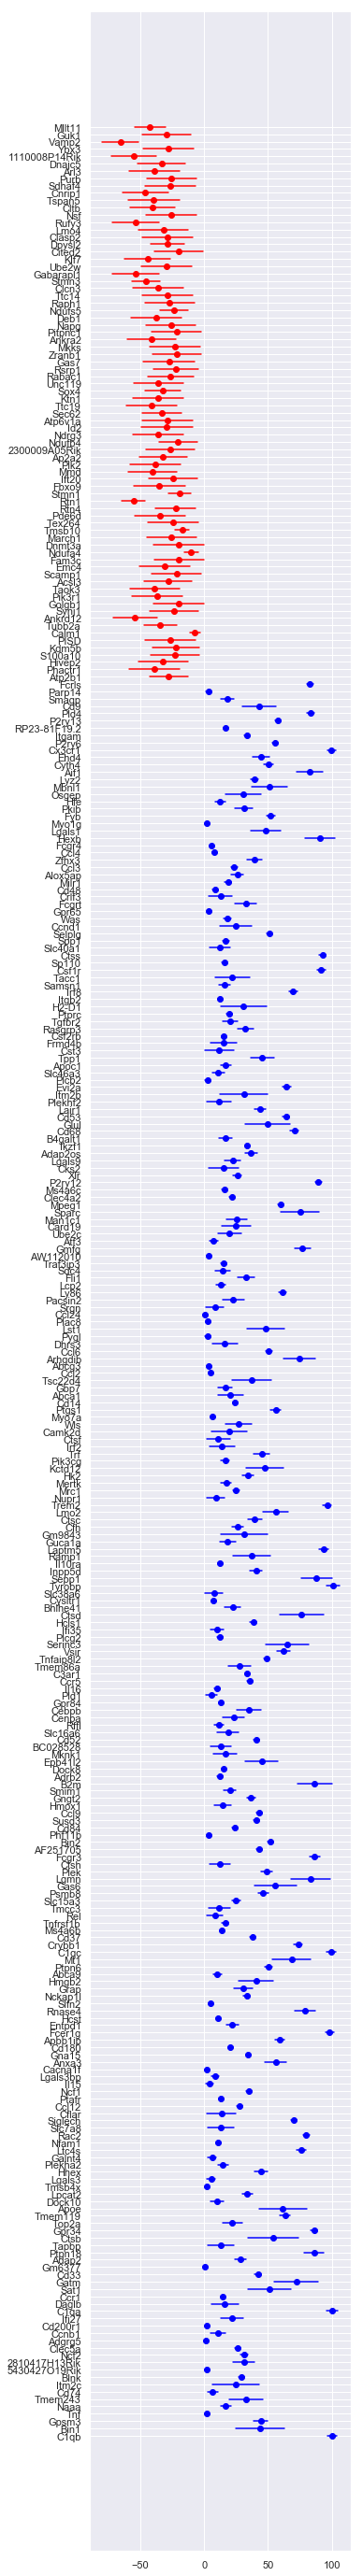

In [18]:
import numpy as np
microglia= dataset_filtered[dataset_filtered.obs['assigned_cell_type'].isin(['Microglia'])].copy()
others= dataset_filtered.obs['assigned_cell_type'].unique().remove_categories('Microglia')
rest = dataset_filtered[dataset_filtered.obs['assigned_cell_type'].isin(list(others))].copy()
print(microglia.shape, rest.shape, dataset_filtered.shape)

microglia.X = np.log2(microglia.X + 1e-30) #log transform for statistical tests
rest.X = np.log2(rest.X + 1e-30) #log transform for statistcal tests

plt.rcParams['figure.figsize']= [5,50]
df58 = scProject.stats.projectionDriver(patterns_filtered, microglia, rest,.999999999999,'gene_short_name', 58)
df25 = scProject.stats.projectionDriver(patterns_filtered, microglia, rest,.999999999999,'gene_short_name', 25)

In [19]:
genes24 = set(df24[0].index)
genes57 = set(df57[0].index)
genes58 = set(df58[0].index)
genes25 = set(df25[0].index)

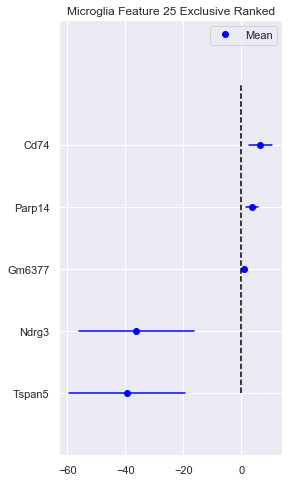

In [20]:
in25 = genes25.difference(genes57).difference(genes58).difference(genes24)
just25CIs = df25[0].loc[in25]

just25CIs['rank'] = (just25CIs['High']+just25CIs['Low'])/2.0
just25CIsRank = just25CIs.sort_values(by='rank', ascending=True)
counter = 0
yAxis = []
plt.rcParams['figure.figsize']= [4, 8]
for idx,low, high,y in zip(list(just25CIsRank.index) ,just25CIsRank['Low'], just25CIsRank['High'], range(len(just25CIsRank))):
    plt.plot((low, high), (counter, counter), '-', color='blue')
    if counter is 0:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue', label='Mean')
    else:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue')
    yAxis.append(idx)
    counter+=1

plt.yticks(range(len(yAxis)), yAxis)
plt.title("Microglia Feature 25 Exclusive Ranked")
plt.plot((0,0), (0,len(yAxis)), '--', color='black')
plt.ylim(top= len(yAxis)+1)
plt.ylim(bottom=-1)
plt.legend()
plt.savefig("25MGvsAll-F57F58F24.pdf", bbox_inches='tight')
plt.show()

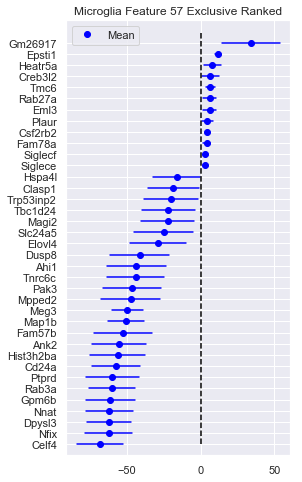

In [21]:
in57 = genes57.difference(genes24).difference(genes58).difference(genes25)
just57CIs = df57[0].loc[in57]

just57CIs['rank'] = (just57CIs['High']+just57CIs['Low'])/2.0
just57CIsRank = just57CIs.sort_values(by='rank', ascending=True)
counter = 0
yAxis = []
plt.rcParams['figure.figsize']= [4, 8]
for idx,low, high,y in zip(list(just57CIsRank.index) ,just57CIsRank['Low'], just57CIsRank['High'], range(len(just57CIsRank))):
    plt.plot((low, high), (counter, counter), '-', color='blue')
    if counter is 0:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue', label='Mean')
    else:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue')
    yAxis.append(idx)
    counter+=1

plt.yticks(range(len(yAxis)), yAxis)
plt.title("Microglia Feature 57 Exclusive Ranked")
plt.plot((0,0), (0,len(yAxis)), '--', color='black')
plt.ylim(top= len(yAxis)+1)
plt.ylim(bottom=-1)
plt.legend()
plt.savefig("57MGvsAll-F25F58F24.pdf", bbox_inches='tight')
plt.show()

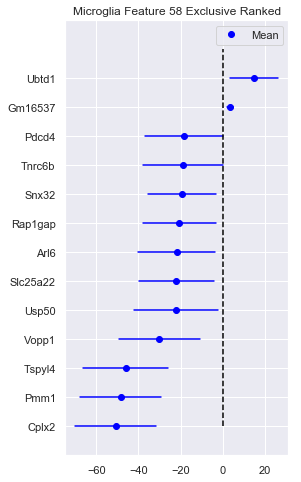

In [22]:
in58 = genes58.difference(genes57).difference(genes25).difference(genes24)
just58CIs = df58[0].loc[in58]

just58CIs['rank'] = (just58CIs['High']+just58CIs['Low'])/2.0
just58CIsRank = just58CIs.sort_values(by='rank', ascending=True)
counter = 0
yAxis = []
plt.rcParams['figure.figsize']= [4, 8]
for idx,low, high,y in zip(list(just58CIsRank.index) ,just58CIsRank['Low'], just58CIsRank['High'], range(len(just58CIsRank))):
    plt.plot((low, high), (counter, counter), '-', color='blue')
    if counter is 0:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue', label='Mean')
    else:
        plt.plot((float(low+high)/2.0), counter,'o', color='blue')
    yAxis.append(idx)
    counter+=1

plt.yticks(range(len(yAxis)), yAxis)
plt.title("Microglia Feature 58 Exclusive Ranked")
plt.plot((0,0), (0,len(yAxis)), '--', color='black')
plt.ylim(top= len(yAxis)+1)
plt.ylim(bottom=-1)
plt.legend()
plt.savefig("58MGvsAll-F57F25F24.pdf", bbox_inches='tight')
plt.show()